# 1 - Raw Data Visualisation

<img src="Images/grideye_camera_view.png" alt="grideye camera view" width="250" height="250" align="left">
<img src="Images/layout.png" alt="layout" width="200" height="200" align="right"> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For some some context here is our setup.   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The left image is our [Panasonic Grid-EYE Evaluation Kit](https://eu.industrial.panasonic.com/grideye-evalkit) connected to a   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Raspberry Pi (for storing data locally)<sup>1</sup>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The Grid-EYE is an 8×8 thermal camera. Just to make that clear, that’s 64 pixels, 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; not megapixels! This super low resolution allows us to stick in sensitive places  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (say a bathroom) without privacy fears  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The right image is the range of view of our Grid-EYE, which is pointing right at   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; the back of a urinal user.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; It's placed for wall-to-wall, floor-to-ceiling viewing.






___
<sup>1</sup> <sub> See our [Medium post](http://www.something.com/) for more info</sub>

In [3]:
import pandas as pd
import numpy as np

import csv
from tqdm import tqdm_notebook,tnrange,tqdm_pandas,tqdm
tqdm.pandas(tqdm())

import os
import cPickle as pickle

import datetime as dt


import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
#notify if cell is finished for cells taking longer than 30 seconds
%autonotify -a 30

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

### Path to your urinal-data-28-nov_clean _pickle_ file

In [4]:
pickle_full = "Data Files/urinal-data-28-nov_clean.p"

### Path to your urinal-data-28-nov_clean [_CSV_](https://drive.google.com/uc?export=download&confirm=AC5G&id=1RaE3ckLvBRfzKpnq61KSp-kZp98Ia7yz) file

In [5]:
csv_full = "Data Files/urinal-data-28-nov_clean.csv"
if not os.path.isfile(csv_full):
    print("Please Download the csv file (link above)")

## Clean Up Our Raw data for analyis
 
read in pickle or read csv, cleanup, and create pickle

In [6]:
  
if os.path.isfile(pickle_full):
    print("loading pickle")
    df = pd.read_pickle(pickle_full)
   
else:
    print("creating pickle...")
    print("this will take some time...")
    df = pd.read_csv(csv_full)
    df.columns = ["time"]+["P"+str(x) for x in range(64)]
    
    # remove dirty data
    df = df[[(x[:2] != "TT") for x in df["time"]]]
    df = df[[x[16:18] != ":S" for x in df["time"]]]
        
    # drop indexes where camera had fallen down/face was in camera
    df = df.drop(range(0,97710+14234), axis=0) #drop row
    df["time"] = df["time"].progress_apply(pd.to_datetime,format="%a %b %d %H:%M:%S %Y") + dt.timedelta(hours=10)
    df = df.set_index('time')
    
    #flip image
    cols = []
    for y in range(7,-1,-1):
            for x in range(8):
                cols.append(x*8+y)
            
    cols = ["P"+str(x) for x in cols] 
    df = df.reindex(columns=cols)
   
    # reset column names
    df.columns = ["P"+str(x) for x in range(64)]
        
    df.to_pickle(pickle_full)


creating pickle...
this will take some time...



  1%|          | 39564/3540394 [00:16<28:34, 2042.10it/s]


  3%|▎         | 103089/3540394 [00:31<07:26, 7702.88it/s]


  6%|▌         | 196183/3540394 [00:45<10:57, 5082.98it/s]


  8%|▊         | 270441/3540394 [00:59<11:57, 4555.66it/s]


  9%|▉         | 320017/3540394 [01:15<13:08, 4086.16it/s]


 11%|█▏        | 402480/3540394 [01:29<08:15, 6327.99it/s]


 13%|█▎        | 474105/3540394 [01:46<13:10, 3880.81it/s]


 16%|█▌        | 567533/3540394 [02:00<06:40, 7418.24it/s]


 18%|█▊        | 651279/3540394 [02:14<10:29, 4587.91it/s]


 19%|█▉        | 688759/3540394 [02:31<07:15, 6547.52it/s]


 22%|██▏       | 767950/3540394 [02:45<10:59, 4206.74it/s]


 23%|██▎       | 831439/3540394 [02:59<09:25, 4788.48it/s]


 25%|██▍       | 874476/3540394 [03:16<25:17, 1756.21it/s]


 26%|██▋       | 937267/3540394 [03:31<06:36, 6557.99it/s]


 29%|██▉       | 1033971/3540394 [03:45<05:32, 7531.04it/s]


 32%|███▏      | 1125008/3540394 [03:59<05:18, 7587.93it/s]


 33%|███▎      | 1163476/3540394 [04:15<27:35, 1435.95it/s]


 33%|███▎      | 1178504/3540394 [04:32<28:16, 1392.03it/s]


 34%|███▍      | 1201419/3540394 [04:46<20:32, 1897.09it/s]


 34%|███▍      | 1210085/3540394 [05:09<1:12:48, 533.38it/s]


 35%|███▍      | 1226311/3540394 [05:24<38:56, 990.31it/s] 


 35%|███▌      | 1243430/3540394 [05:40<50:36, 756.40it/s]


 36%|███▌      | 1267714/3540394 [05:55<14:38, 2588.35it/s]


 37%|███▋      | 1296917/3540394 [06:10<14:26, 2589.76it/s]


 37%|███▋      | 1323761/3540394 [06:26<12:42, 2906.46it/s]


 39%|███▊      | 1371878/3540394 [06:41<14:02, 2573.17it/s]


 40%|████      | 1423678/3540394 [06:57<05:24, 6524.13it/s]


 41%|████      | 1459365/3540394 [07:14<19:04, 1818.32it/s]


 42%|████▏     | 1495475/3540394 [07:31<11:31, 2955.67it/s]


 44%|████▍     | 1560701/3540394 [07:48<18:08, 1818.23it/s]


 45%|████▌     | 1599436/3540394 [08:03<20:38, 1567.06it/s]


 47%|████▋     | 1674348/3540394 [08:20<11:22, 2734.58it/s]


 49%|████▉     | 1743344/3540394 [08:36<07:01, 4265.05it/s]


 51%|█████▏    | 1814977/3540394 [08:52<06:03, 4744.58it/s]


 53%|█████▎    | 1891606/3540394 [09:08<03:57, 6948.36it/s]


 55%|█████▌    | 1960914/3540394 [09:24<07:56, 3313.24it/s]


 57%|█████▋    | 2014361/3540394 [09:41<04:08, 6136.67it/s]


 59%|█████▉    | 2085385/3540394 [09:56<27:27, 883.36it/s]


 60%|█████▉    | 2114660/3540394 [10:12<13:42, 1733.02it/s]


 61%|██████    | 2144651/3540394 [10:26<09:20, 2490.69it/s]


 61%|██████▏   | 2172470/3540394 [10:40<10:00, 2277.53it/s]


 62%|██████▏   | 2201156/3540394 [10:55<15:25, 1447.35it/s]


 64%|██████▍   | 2267332/3540394 [11:10<09:11, 2307.47it/s]


 66%|██████▌   | 2322791/3540394 [11:24<04:01, 5033.86it/s]


 68%|██████▊   | 2392335/3540394 [11:38<02:47, 6843.59it/s]


 70%|██████▉   | 2471038/3540394 [11:52<04:01, 4425.05it/s]


 71%|███████   | 2509978/3540394 [12:08<08:10, 2099.17it/s]


 72%|███████▏  | 2551891/3540394 [12:23<04:06, 4002.51it/s]


 74%|███████▎  | 2610498/3540394 [12:37<02:29, 6201.77it/s]


 76%|███████▌  | 2677962/3540394 [12:52<02:33, 5636.21it/s]


 76%|███████▋  | 2707902/3540394 [13:07<09:56, 1396.46it/s]


 77%|███████▋  | 2733836/3540394 [13:21<12:58, 1035.70it/s]


 78%|███████▊  | 2756104/3540394 [13:37<07:15, 1800.93it/s]


 78%|███████▊  | 2774332/3540394 [13:51<07:33, 1689.86it/s]


 79%|███████▉  | 2795426/3540394 [14:04<06:58, 1780.19it/s]


 80%|███████▉  | 2817011/3540394 [14:18<06:52, 1754.19it/s]


 80%|████████  | 2838066/3540394 [14:33<06:57, 1681.86it/s]


 81%|████████  | 2866604/3540394 [14:47<06:28, 1735.05it/s]


 82%|████████▏ | 2897336/3540394 [15:01<05:05, 2105.95it/s]


 83%|████████▎ | 2921470/3540394 [15:15<05:28, 1886.22it/s]


 83%|████████▎ | 2953478/3540394 [15:29<01:50, 5301.72it/s]


 86%|████████▌ | 3028512/3540394 [15:44<02:16, 3750.20it/s]


 87%|████████▋ | 3071128/3540394 [16:01<02:59, 2608.50it/s]


 89%|████████▉ | 3153870/3540394 [16:15<01:23, 4625.19it/s]


 91%|█████████ | 3222907/3540394 [16:30<00:58, 5462.59it/s]


 93%|█████████▎| 3299060/3540394 [16:44<00:34, 6940.98it/s]


 96%|█████████▌| 3386298/3540394 [16:58<00:27, 5645.25it/s]


 98%|█████████▊| 3474141/3540394 [17:12<00:10, 6066.25it/s]


100%|██████████| 3540394/3540394 [17:26<00:00, 3384.69it/s]

<IPython.core.display.Javascript object>

### Raw Data
Our dataframe is a composed of rows containing the 64 (8x8) thermal sensor Pixels of the Grid-EYE.    
with column P0 - P7 the top line of pixels, and P56 - P63 the bottom line.  
Each value therefore corresponds to a temperature in <sup>o</sup>C  
Each row is timestamped

In [7]:
df.sample(5)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P54,P55,P56,P57,P58,P59,P60,P61,P62,P63
time,,,,,,,,,,,,,,,,,,,,,
2017-11-26 02:47:21,22.25,24.00,22.50,22.50,22.25,23.00,22.75,22.0,22.50,22.50,...,22.00,21.50,22.25,22.50,22.50,21.75,23.50,24.00,22.50,21.25
2017-11-26 00:45:43,22.00,23.25,21.50,23.00,23.00,23.00,23.25,22.5,22.50,22.25,...,21.50,21.75,23.25,23.25,22.75,22.75,22.75,22.25,22.00,23.75
2017-11-27 16:30:06,21.75,22.75,22.75,21.50,23.00,22.25,23.50,23.0,21.75,23.25,...,22.75,23.25,21.50,22.75,22.50,22.75,25.00,23.25,21.75,22.25
2017-11-26 09:15:21,22.25,22.50,22.25,22.25,22.50,22.50,23.75,23.5,22.50,23.25,...,22.50,22.00,21.25,22.75,23.75,23.75,24.25,24.00,21.50,23.50
2017-11-24 19:02:27,22.75,22.50,22.50,22.50,22.75,23.25,22.75,23.5,23.00,23.50,...,22.25,21.75,22.00,23.00,23.25,22.25,23.25,23.50,21.75,22.50


### Urinal Section Visualisation
Below you can see the the Urinal positions (_Left_, _Middle_, and _Right_) with respect to the camera.  
The back of a head sits around row 3 or 4 (depending on height).    
Also annotated is the _Empty Space_,   
since no-one in our office is taller than 7 foot we'll never have a visitor in this region.

IOError: [Errno 2] No such file or directory: 'IMages/layout_sections.png'

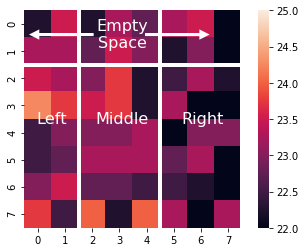

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

frame = np.array(df.iloc[0]).reshape(8,8).astype('float')

ax = sns.heatmap(frame, vmin=22, vmax=25,square=True)
ax.vlines([2, 5, 8], *ax.get_xlim(),color='white', linewidth=4)
ax.hlines([2], *ax.get_xlim(),color='white', linewidth=4)
ax.text(0.125, 0.5,'Left', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);
ax.text(0.45, 0.5,'Middle', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);

ax.text(0.82, 0.5,'Right', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);

ax.text(0.45, 0.89,'Empty\nSpace', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,
       color='white',size=16);
ax.arrow(2.5, 0.89, -2, 0, head_width=0.2, head_length=0.2, fc='w', ec='w',linewidth=3)
ax.arrow(4.5, 0.89, 2, 0, head_width=0.2, head_length=0.2, fc='w', ec='w',linewidth=3)

plt.savefig('IMages/layout_sections.png', dpi=600)

## Visualise Our Data!
We have an 8x8 grid of thermal pixels: Seaborns heatmap is perfect here.


Below we'll look at a typical instance of a person walking in and out of our area of interest.  
This particular person visited the left urinal at 4 pm on a Friday.  
### Animation of a Walk in
Here you can see a person walking in to use the left Urinal.

In [ ]:
startIn = df.index.searchsorted(dt.datetime(2017, 11, 24, 15, 59,37,0))
endIn = df.index.searchsorted(dt.datetime(2017, 11, 24, 15,59,41,0))

In [ ]:
framesIn = []
for row in df.iloc[startIn:endIn].iterrows():
        framesIn.append(np.array(row[1]).reshape(8,8).astype('float'))


In [ ]:
# Low res animation

plt.style.use('ggplot')
plt.rcParams['animation.writer'] = 'ffmpeg'
# print(matplotlib.animation.writers.list())
from matplotlib import animation, rc
from IPython.display import HTML

# fig, ax = plt.subplots()
# fig.set_tight_layout(True)
fig = plt.figure()

def init():
    plt.clf()
    sns.heatmap(np.zeros((8, 8)),vmin=22,vmax=25,square=True)
    plt.clf()
#     return (sns,)

def animate(i):
    plt.clf()
    data = framesIn[i]
    sns.heatmap(data, vmin=22,vmax=25,square=True)
#     return (sns,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(framesIn),interval=100,repeat=True)#,blit = True)
HTML(anim.to_html5_video())

#need to return a seaborn object with an "artist object"
#in order to use blit (and therefore speed up rendering)


### Animation of a Walk Out

In [ ]:
startOut = df.index.searchsorted(dt.datetime(2017, 11, 24, 16,0,3,0))
endOut = df.index.searchsorted(dt.datetime(2017, 11, 24, 16,0,7,0))

In [ ]:
framesOut = []
for row in df.iloc[startOut:endOut].iterrows():
        framesOut.append(np.array(row[1]).reshape(8,8).astype('float'))



In [ ]:
# Low res animation
plt.rcParams['animation.writer'] = 'ffmpeg'
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()
# fig = plt.figure()

def init():
    plt.clf()
    sns.heatmap(np.zeros((8, 8)),vmin=22,vmax=25,square=True)
    plt.clf()
#     return (sns,)

def animate(i):
    plt.clf()
    data = framesOut[i]
    sns.heatmap(data, vmin=22,vmax=25,square=True)
#     return (sns,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(framesOut),interval=100,repeat=True)#,blit = True)
HTML(anim.to_html5_video())

#need to return a seaborn object with an "artist object"
#in order to use blit (and therefore speed up rendering)


You might have noticed how noisy the data is.
There are two main reasons for this.
1. The accuracy and precision of the Grideye is low (&pm;2.5&deg;C, and &pm;0.25&deg;C respectively) <sup>[1](https://industrial.panasonic.com/cdbs/www-data/pdf/ADI8000/ADI8000C53.pdf)</sup>
2. Temperature of air varies in a ventilated (HVAC) system, often more than the Grideye's precision <sup>[2](https://www.sciencedirect.com/science/article/pii/S0360132396000340)</sup>
 
Next we'll figure out how to find a person in this mess of pixels

Go to 2 - __Algorithm Design__